In [90]:
import gym
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import seaborn as sns
import pandas as pd

from unityagents import UnityEnvironment

from trainer import trainer
from dqn_agent import Agent as DQNAgent

import pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

plt.style.use('ggplot')

In [ ]:
env = UnityEnvironment(file_name='Banana_Linux_NoVis/Banana.x86')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

In [ ]:
def multiple_runs(agent, environment, brain_name, runs=5, 
                  n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
                  score_solved=13.0, save_model=False, model_filename=None):
    scores_list = list()
    episodes_list = list()
    elapsed_time_list = list()
    for i in range(0,runs):
        start_time = time.time()
        scores, episodes = trainer(agent, env, brain_name, 
                                   n_episodes=n_episodes, max_t=max_t, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay, 
                                   score_solved=score_solved, save_model=save_model, model_filename=model_filename)
        elapsed_time = round(time.time() - start_time, 2)
        
        scores_list.append(scores)
        episodes_list.append(episodes)
        elapsed_time_list.append(elapsed_time)
        
    return scores_list, episodes_list, elapsed_time_list

# 1. Randomness on different runs

In [ ]:
# Run multiple runs
runs = 10
agent = DQNAgent(state_size=state_size, action_size=action_size)
scores_list, episodes_list, elapsed_time_list = multiple_runs(agent, env, brain_name, runs=runs, save_model=False)

In [ ]:
# Save
with open('results/scores_list_randomness', 'wb') as fp:
    pickle.dump(scores_list, fp)
with open('results/episodes_list_randomness', 'wb') as fp:
    pickle.dump(episodes_list, fp)
with open('results/elapsed_time_list_randomness', 'wb') as fp:
    pickle.dump(elapsed_time_list, fp)

# 2. Hyperparameters

## Network Structure

In [ ]:
layers_list = [2, 3, 4]
units_list = [32, 64, 128]

for n_layers in layers_list:
    for n_units in units_list:
        # Run multiple runs
        agent = DQNAgent(state_size=state_size, action_size=action_size, network_layers=n_layers, network_units=n_units)
        scores_list, episodes_list, elapsed_time_list = multiple_runs(agent, env, brain_name, save_model=False)

        # Save
        with open('results/scores_list_network_L' + str(n_layers) + '_U' + str(n_units), 'wb') as fp:
            pickle.dump(scores_list, fp)
        with open('results/episodes_list_network_L' + str(n_layers) + '_U' + str(n_units), 'wb') as fp:
            pickle.dump(episodes_list, fp)
        with open('results/elapsed_time_list_network_L' + str(n_layers) + '_U' + str(n_units), 'wb') as fp:
            pickle.dump(elapsed_time_list, fp)

## Learning rate

In [ ]:
lr_list = [5e-2, 5e-3, 5e-4, 5e-5]

for lr in lr_list:
    
    # Run multiple runs
    agent = DQNAgent(state_size=state_size, action_size=action_size, lr=lr)
    scores_list, episodes_list, elapsed_time_list = multiple_runs(agent, env, brain_name, save_model=False)

    # Save
    with open('results/scores_list_lr' + str(lr), 'wb') as fp:
        pickle.dump(scores_list, fp)
    with open('results/episodes_list_lr' + str(lr), 'wb') as fp:
        pickle.dump(episodes_list, fp)
    with open('results/elapsed_time_list_lr' + str(lr), 'wb') as fp:
        pickle.dump(elapsed_time_list, fp)

## Epsilon decay

In [ ]:
eps_decay_list = [0.99, 0.995, 0.9995, 0.99995]

for eps_decay in eps_decay_list:
    
    # Run multiple runs
    agent = DQNAgent(state_size=state_size, action_size=action_size)
    scores_list, episodes_list, elapsed_time_list = multiple_runs(agent, env, brain_name, eps_decay=eps_decay, save_model=False)

    # Save
    with open('results/scores_list_eps' + str(eps_decay), 'wb') as fp:
        pickle.dump(scores_list, fp)
    with open('results/episodes_list_eps' + str(eps_decay), 'wb') as fp:
        pickle.dump(episodes_list, fp)
    with open('results/elapsed_time_list_eps' + str(eps_decay), 'wb') as fp:
        pickle.dump(elapsed_time_list, fp)

# 3. Results

## Randomness on different runs 

Even fixing the seed, the score curves over different runs are different. This is probably due to some randomness in the unity environment that we are not controlling. Due to this, all the following hyperparameter explorations will be averaged over multiple runs.

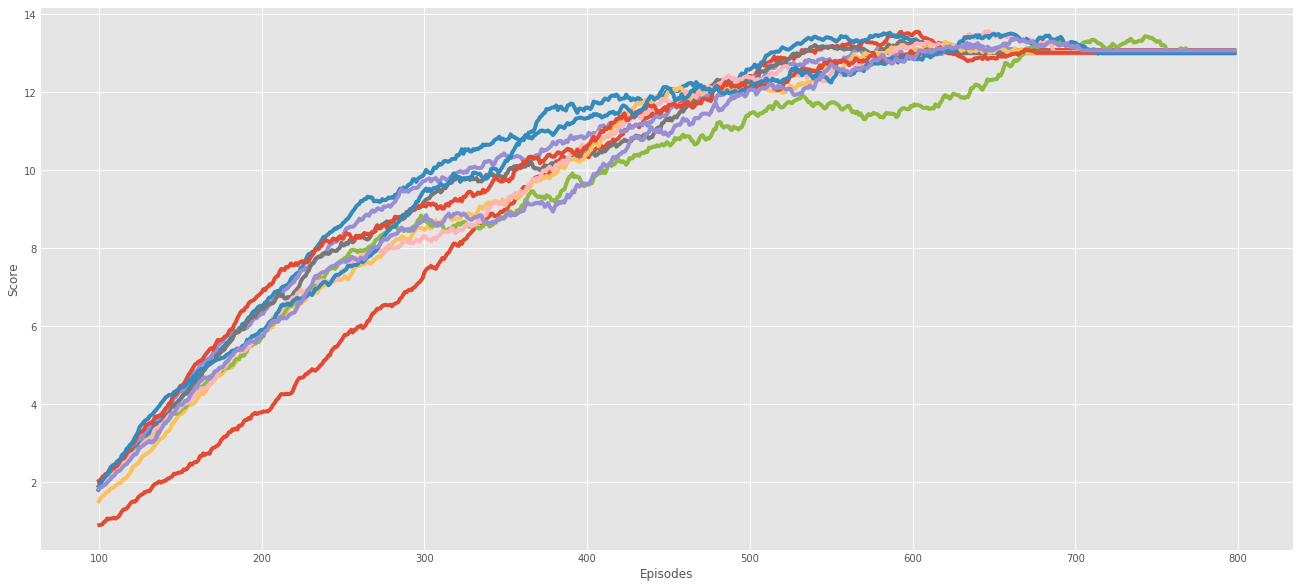

Average number of episodes:  577.0
Average elapsed time:  345.494
Average time per episode:  0.5985101039405103


In [103]:
with open('results/scores_list_randomness', 'rb') as fp:
    scores_list = pickle.load(fp)
with open('results/episodes_list_randomness', 'rb') as fp:
    episodes_list = pickle.load(fp)
with open('results/elapsed_time_list_randomness', 'rb') as fp:
    elapsed_time_list = pickle.load(fp)

scores = np.array([np.concatenate([np.array(run), np.mean(np.array(run)[-100:])*np.ones(max_len-len(run))]) for run in scores_list])[:, :800]
plt.figure(figsize=(20,10))
plt.plot(pd.DataFrame(scores.T).rolling(100).mean())
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

print("Average number of episodes: ", np.mean(episodes_list))
print("Average elapsed time: ", np.mean(elapsed_time_list))
print("Average time per episode: ", np.mean(np.array(elapsed_time_list) / np.array(episodes_list)))

## Network structure

Here we study the impact of network architecture, by changing the number of hidden layers and the nodes per each layer. The 3x3 combinations we tried are defined here

```
layers_list = [2, 3, 4]
units_list = [32, 64, 128]
```

As expected, the less layers and units, the fastest the single episode. 

But, different network structures can lead to faster convergence (with less episodes). Taking into account the combination of those effects, the best choice in terms total elapsed time seems to be a 3 layer network with 32 or 64 nodes.

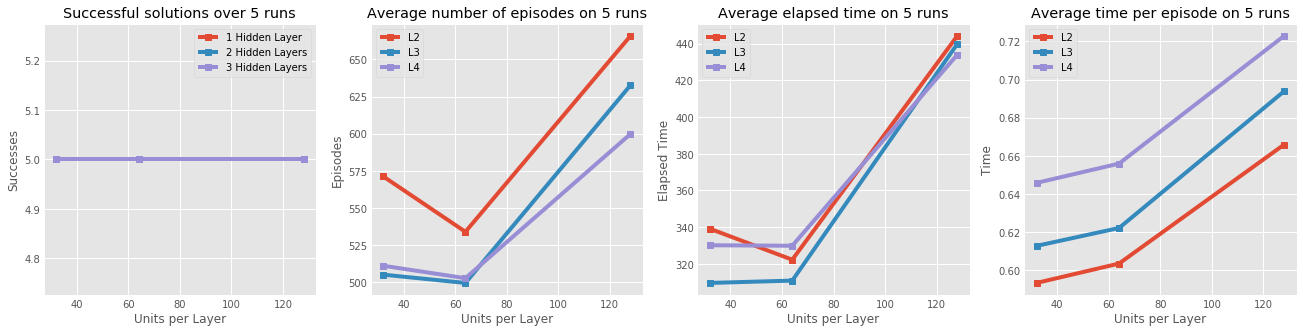

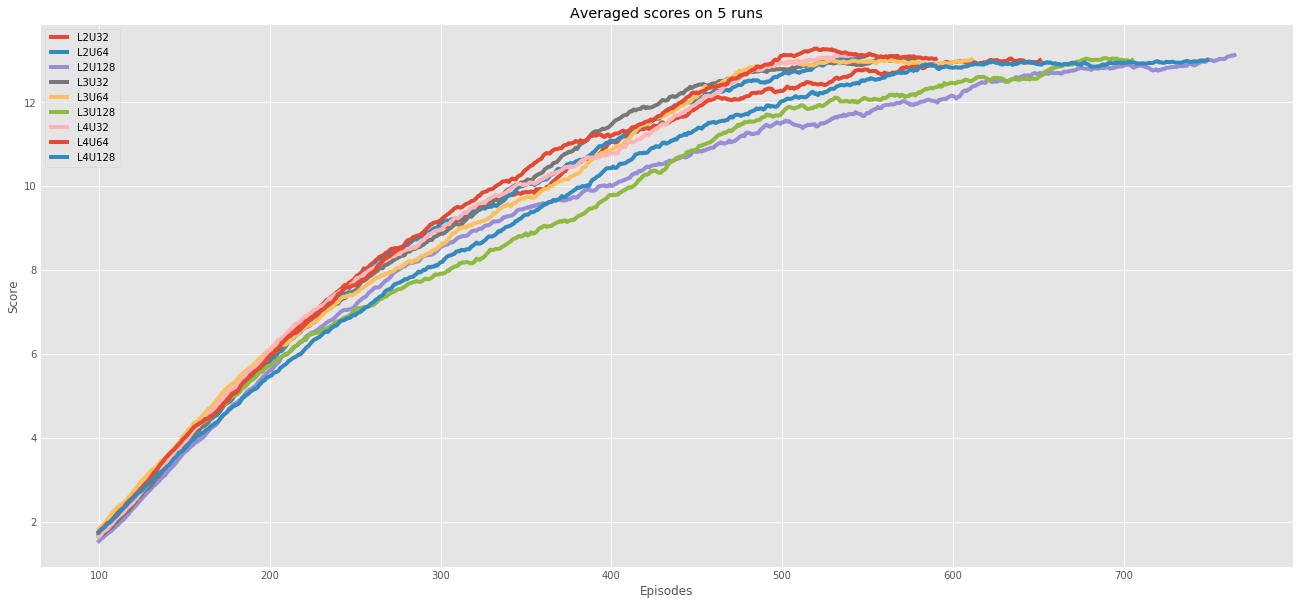

In [104]:
layers_list = [2, 3, 4]
units_list = [32, 64, 128]

scores_list_dict = dict()
episodes_list_dict = dict()
elapsed_time_list_dict = dict()
for n_layers in layers_list:
    for n_units in units_list:

        with open('results/scores_list_network_L' + str(n_layers) + '_U' + str(n_units), 'rb') as fp:
            scores_list_dict['L'+str(n_layers)+'U'+str(n_units)] = pickle.load(fp)
        with open('results/episodes_list_network_L' + str(n_layers) + '_U' + str(n_units), 'rb') as fp:
            episodes_list_dict['L'+str(n_layers)+'U'+str(n_units)] = pickle.load(fp)
        with open('results/elapsed_time_list_network_L' + str(n_layers) + '_U' + str(n_units), 'rb') as fp:
            elapsed_time_list_dict['L'+str(n_layers)+'U'+str(n_units)] = pickle.load(fp)
            
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(units_list, [sum(np.array(episodes_list_dict['L2U'+str(u)]) != 2000) for u in units_list], 's-', label='L2')
plt.plot(units_list, [sum(np.array(episodes_list_dict['L3U'+str(u)]) != 2000) for u in units_list], 's-', label='L3')
plt.plot(units_list, [sum(np.array(episodes_list_dict['L4U'+str(u)]) != 2000) for u in units_list], 's-', label='L4')
plt.ylabel('Successes')
plt.xlabel('Units per Layer')
plt.title('Successful solutions over 5 runs')
plt.legend()
plt.subplot(142)
plt.plot(units_list, [np.mean(episodes_list_dict['L2U'+str(u)]) for u in units_list], 's-', label='L2')
plt.plot(units_list, [np.mean(episodes_list_dict['L3U'+str(u)]) for u in units_list], 's-', label='L3')
plt.plot(units_list, [np.mean(episodes_list_dict['L4U'+str(u)]) for u in units_list], 's-', label='L4')
plt.legend()
plt.ylabel('Episodes')
plt.xlabel('Units per Layer')
plt.title('Average number of episodes on 5 runs')
plt.subplot(143)
plt.plot(units_list, [np.mean(elapsed_time_list_dict['L2U'+str(u)]) for u in units_list], 's-', label='L2')
plt.plot(units_list, [np.mean(elapsed_time_list_dict['L3U'+str(u)]) for u in units_list], 's-', label='L3')
plt.plot(units_list, [np.mean(elapsed_time_list_dict['L4U'+str(u)]) for u in units_list], 's-', label='L4')
plt.legend()
plt.ylabel('Elapsed Time')
plt.xlabel('Units per Layer')
plt.title('Average elapsed time on 5 runs')
plt.subplot(144)
plt.plot(units_list, [np.mean(np.array(elapsed_time_list_dict['L2U'+str(u)]) / np.array(episodes_list_dict['L2U'+str(u)])) for u in units_list], 's-', label='L2')
plt.plot(units_list, [np.mean(np.array(elapsed_time_list_dict['L3U'+str(u)]) / np.array(episodes_list_dict['L3U'+str(u)])) for u in units_list], 's-', label='L3')
plt.plot(units_list, [np.mean(np.array(elapsed_time_list_dict['L4U'+str(u)]) / np.array(episodes_list_dict['L4U'+str(u)])) for u in units_list], 's-', label='L4')
plt.legend()
plt.ylabel('Time')
plt.xlabel('Units per Layer')
plt.title('Average time per episode on 5 runs')
plt.show()

plt.figure(figsize=(20,10))
for key, value in scores_list_dict.items():
    max_len = max([len(run) for run in value])
    scores = np.array([np.concatenate([np.array(run), np.mean(np.array(run)[-100:])*np.ones(max_len-len(run))]) for run in value])      
    average_score = np.mean(scores, axis=0)
    rolled_scores = pd.DataFrame(average_score).rolling(100).mean()
    plt.plot(rolled_scores, label=key)
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.title("Averaged scores on 5 runs")
plt.legend()
plt.show()

## Learning rate

Here we study the impact of learning rate. We simulated 4 different rates: `lr_list = [5e-2, 5e-3, 5e-4, 5e-5]`

Highest learning rates (5e-2, 5e-3) do not - or not always - achieve the solution in the 2000 episodes. In particular, the highest one, 5e-2, leads the network to complete instability and does not allow the network to learn. Among 5e-4 and 5e-5, the first seems to require less episodes on average, while the smallest one is reasonably slower.

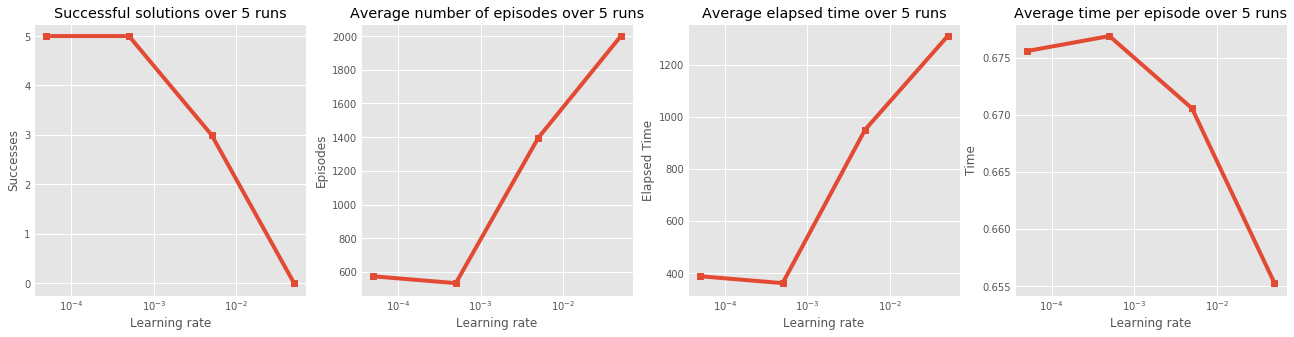

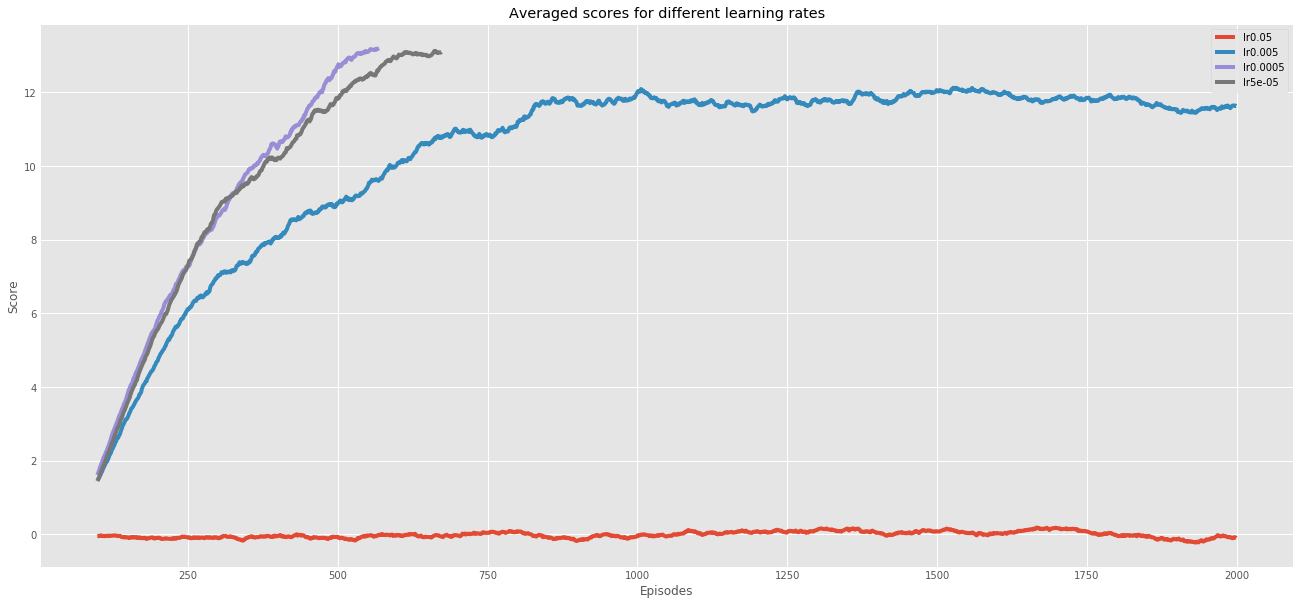

In [94]:
lr_list = [5e-2, 5e-3, 5e-4, 5e-5]

scores_list_dict = dict()
episodes_list_dict = dict()
elapsed_time_list_dict = dict()

for lr in lr_list:
    with open('results/scores_list_lr' + str(lr), 'rb') as fp:
        scores_list_dict['lr' + str(lr)] = pickle.load(fp)
    with open('results/episodes_list_lr' + str(lr), 'rb') as fp:
        episodes_list_dict['lr' + str(lr)] = pickle.load(fp)
    with open('results/elapsed_time_list_lr' + str(lr), 'rb') as fp:
        elapsed_time_list_dict['lr' + str(lr)] = pickle.load(fp)
            
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.semilogx(lr_list, [sum(np.array(episodes_list_dict['lr' + str(lr)]) != 2000) for lr in lr_list], 's-')
plt.ylabel('Successes')
plt.xlabel('Learning rate')
plt.title('Successful solutions over 5 runs')
plt.subplot(142)
plt.semilogx(lr_list, [np.mean(episodes_list_dict['lr' + str(lr)]) for lr in lr_list], 's-')
plt.ylabel('Episodes')
plt.xlabel('Learning rate')
plt.title('Average number of episodes over 5 runs')
plt.subplot(143)
plt.semilogx(lr_list, [np.mean(elapsed_time_list_dict['lr' + str(lr)]) for lr in lr_list], 's-')
plt.ylabel('Elapsed Time')
plt.xlabel('Learning rate')
plt.title('Average elapsed time over 5 runs')
plt.subplot(144)
plt.semilogx(lr_list, [np.mean(np.array(elapsed_time_list_dict['lr' + str(lr)]) / np.array(episodes_list_dict['lr' + str(lr)])) for lr in lr_list], 's-')
plt.ylabel('Time')
plt.xlabel('Learning rate')
plt.title('Average time per episode over 5 runs')
plt.show()

plt.figure(figsize=(20,10))
for key, value in scores_list_dict.items():
    max_len = max([len(run) for run in value])
    scores = np.array([np.concatenate([np.array(run), np.mean(np.array(run)[-100:])*np.ones(max_len-len(run))]) for run in value])      
    average_score = np.mean(scores, axis=0)
    rolled_scores = pd.DataFrame(average_score).rolling(100).mean()
    plt.plot(rolled_scores, label=key)
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.title("Averaged scores for different learning rates")
plt.legend()
plt.show()

## Epsilon decay

Here we study the impact of epsilon decay. We simulated 4 different decays: `eps_decay_list = [0.99, 0.995, 0.9995, 0.99995]`

Too small decays (0.9995, 0.99995) do not allow the network achieve the solution in the 2000 episodes. But, as shown by the scores, differently from the case of learning rate, this is not due to instability of the network, but to a very slow convergence to the "right" actions due to the fact the agent explores a lot.

Among 0.99 and 0.995, the smaller decay solves the environment faster, but seems to achieve a slightly lower final score, which again would be reasonable considering the less frequent exploration.

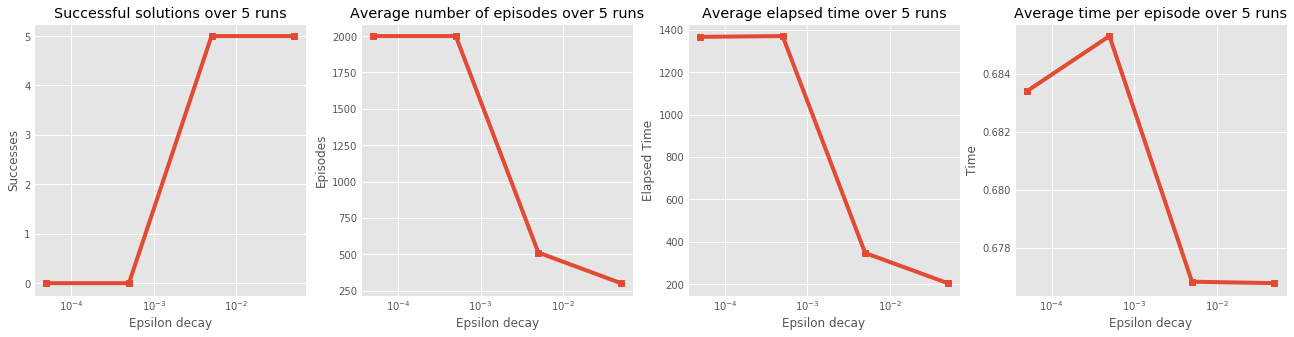

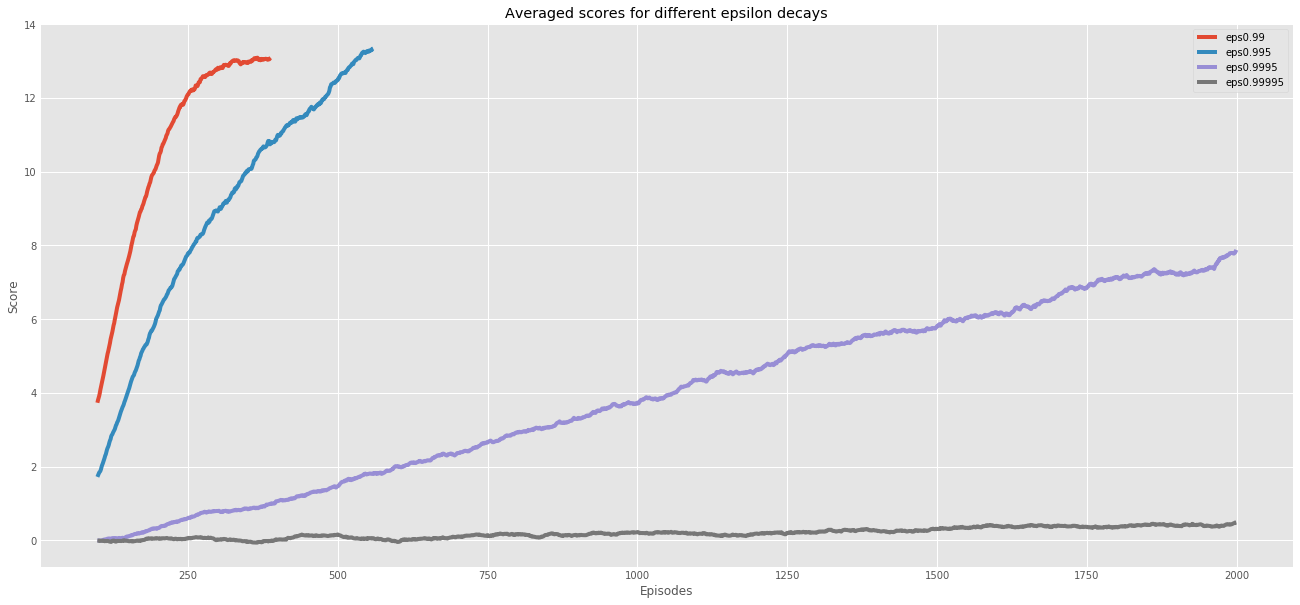

In [95]:
scores_list_dict = dict()
episodes_list_dict = dict()
elapsed_time_list_dict = dict()

for eps_decay in eps_decay_list:
    with open('results/scores_list_eps' + str(eps_decay), 'rb') as fp:
        scores_list_dict['eps' + str(eps_decay)] = pickle.load(fp)
    with open('results/episodes_list_eps' + str(eps_decay), 'rb') as fp:
        episodes_list_dict['eps' + str(eps_decay)] = pickle.load(fp)
    with open('results/elapsed_time_list_eps' + str(eps_decay), 'rb') as fp:
        elapsed_time_list_dict['eps' + str(eps_decay)] = pickle.load(fp)
            
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.semilogx(lr_list, [sum(np.array(episodes_list_dict['eps' + str(eps_decay)]) != 2000) for eps_decay in eps_decay_list], 's-')
plt.ylabel('Successes')
plt.xlabel('Epsilon decay')
plt.title('Successful solutions over 5 runs')
plt.subplot(142)
plt.semilogx(lr_list, [np.mean(episodes_list_dict['eps' + str(eps_decay)]) for eps_decay in eps_decay_list], 's-')
plt.ylabel('Episodes')
plt.xlabel('Epsilon decay')
plt.title('Average number of episodes over 5 runs')
plt.subplot(143)
plt.semilogx(lr_list, [np.mean(elapsed_time_list_dict['eps' + str(eps_decay)]) for eps_decay in eps_decay_list], 's-')
plt.ylabel('Elapsed Time')
plt.xlabel('Epsilon decay')
plt.title('Average elapsed time over 5 runs')
plt.subplot(144)
plt.semilogx(lr_list, [np.mean(np.array(elapsed_time_list_dict['eps' + str(eps_decay)]) / np.array(episodes_list_dict['eps' + str(eps_decay)])) for eps_decay in eps_decay_list], 's-')
plt.ylabel('Time')
plt.xlabel('Epsilon decay')
plt.title('Average time per episode over 5 runs')
plt.show()

plt.figure(figsize=(20,10))
for key, value in scores_list_dict.items():
    max_len = max([len(run) for run in value])
    scores = np.array([np.concatenate([np.array(run), np.mean(np.array(run)[-100:])*np.ones(max_len-len(run))]) for run in value])      
    average_score = np.mean(scores, axis=0)
    rolled_scores = pd.DataFrame(average_score).rolling(100).mean()
    plt.plot(rolled_scores, label=key)
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.title("Averaged scores for different epsilon decays")
plt.legend()
plt.show()